# The Distribution of Wealth and the MPC


This notebook presents a selection of results from the paper [The Distribution of Wealth and the Marginal Propensity to Consume](http://econ.jhu.edu/people/ccarroll/papers/cstwMPC), using the [Econ-ARK/HARK](https://github.com/econ-ark/HARK) toolkit. It sketches the steps that would need to be taken to solve the model using the [dolARK](https://github.com/EconForge/dolARK) modeling system.


In [1]:
# This cell does some standard python setup!

import code.calibration as parameters
import warnings  # The warnings package allows us to ignore some harmless but alarming warning messages
from code.calibration import SCF_wealth, SCF_weights
from code.estimation import estimate

# Import related generic python packages
import matplotlib.pyplot as plt  # Plotting tools
import numpy as np
from HARK.utilities import get_lorenz_shares

warnings.filterwarnings("ignore")


def mystr(number):
    return f"{number:.4f}"

## Abstract

In a model calibrated to match micro- and macroeconomic evidence on household income dynamics, this paper shows that a modest degree of heterogeneity in household preferences or beliefs is sufficient to match empirical measures of wealth inequality in the U.S. The hegerogeneity-augmented model's predictions are consistent with microeconomic evidence that suggests that the annual marginal propensity to consume (MPC) is much larger than the roughly 0.04 implied by commonly-used macroeconomic models (even ones including some heterogeneity). The high MPC arises because many consumers hold little wealth despite having a strong precautionary motive. The model also plausibly predicts that the aggregate MPC can differ greatly depending on how the shock is distributed across households (depending, e.g., on their wealth, or employment status).


## Notation For the Core Model

We define the following notation.

|    Exogenous Random Variable     | Description       | Code            | Value |
| :------------------------------: | ----------------- | --------------- | :---: |
| $\newcommand{\tshk}{\zeta}\tshk$ | Transitory Income | $\texttt{tshk}$ |       |
| $\newcommand{\pshk}{\psi}\pshk$  | Permanent Shock   | $\texttt{pshk}$ |       |

|                Parameter                 | Description                          | Code                  |  Value  |
| :--------------------------------------: | ------------------------------------ | --------------------- | :-----: |
| $\newcommand{\PLives}{\Lambda} \PLives$  | Probability of living                | $\texttt{PLives}$     | 0.99375 |
| $\newcommand{\Discount}{\beta}\Discount$ | Time Preference Factor               | $\texttt{Discount}$   |  0.96   |
|     $\newcommand{\CRRA}{\rho}\CRRA$      | Coeﬃcient of Relative Risk Aversion  | $\texttt{CRRA}$       |    1    |
|              $\sigma_\tshk$              | Transitory Income Standard Deviation | $\texttt{PermShkStd}$ |   0.1   |
|              $\sigma_\pshk$              | Permanent Shock Standard Deviation   | $\texttt{TranShkStd}$ |   0.1   |

|                 Variable                  | Description         | Code                |
| :---------------------------------------: | ------------------- | ------------------- |
|       $\newcommand{\aRat}{a}\aRat$        | Assets              | $\texttt{aRat}$     |
|       $\newcommand{\mRat}{m}\mRat$        | Market resources    | $\texttt{mRt}$      |
|       $\newcommand{\KLev}{K}\KLev$        | Capital Aggregate   | $\texttt{KLev}$     |
| $\newcommand{\kapShare}{\alpha}\kapShare$ | Capital share       | $\texttt{kapShare}$ |
|       $\newcommand{\LLev}{L}\LLev$        | Labor Aggregate     | $\texttt{LLev}$     |
|     $\newcommand{\labor}{\ell}\labor$     | Labor share         | $\texttt{labor}$    |
|       $\newcommand{\kRat}{k}\kRat$        | $K/P$               | $\texttt{kRat}$     |
|       $\newcommand{\pRat}{p}\pRat$        | Permanent Income    |                     |
|               $\mathbf{P}$                |                     |                     |
|      $\newcommand{\rProd}{r}\rProd$       | Interest rate       | $\texttt{rProd}$    |
|       $\newcommand{\yLev}{y} \yLev$       | Income              | $\texttt{yLev}$     |
|       $\newcommand{\Wage}{W}\Wage$        | Aggregate Wage Rate | $\texttt{Wage}$     |

|                 Functions                 | Description | Code             | Value |
| :---------------------------------------: | ----------- | ---------------- | :---: |
|  $\newcommand{\cFunc}{\mathrm{c}}\cFunc$  | Consumption | $\texttt{cFunc}$ |       |
| $\newcommand{\valfn}{\mathrm{v}} \valfn$  | Value       | $\texttt{valfn}$ |
| $\newcommand{\uFunc}{{\mathrm{u}}}\uFunc$ | Utility     | $\texttt{uFunc}$ |       |

$\newcommand{\cRat}{c}$
$\newcommand{\Ex}{\mathbb{E}}$
$\newcommand{\PDies}{\mathsf{P}}$
$\newcommand{\ptyLev}{a}$
$\newcommand{\YLev}{Y}$
$\newcommand{\wEndRat}{\aRat}$


The consumer has a standard Constant Relative Risk Aversion utility function $$u(c)=\frac{c^{1-\rho}}{1-\rho}$$


The idiosyncratic (household) income process is logarithmic Friedman:
\begin{align*}
\yLev_{t+1} & = \pRat_{t+1}\tshk_{t+1}\Wage\\
\pRat_{t+1} & = \pRat_{t}\pshk_{t+1}
\end{align*}


The Bellman form of the value function for households is:

\begin{align*}
\valfn(\mRat_{t}) & = \underset{\cFunc_{t}}{\max } ~~ \uFunc(\cFunc_{t}(\mRat_{t}))+\Discount \PLives \Ex_{t}\left[ \pshk_{t+1}^{1-\CRRA}\valfn(\mRat_{t+1})
\right] \\
\notag & \text{s.t.}\\
\wEndRat_{t} & = \mRat_{t}-\cRat_{t},\\
\wEndRat_{t} & \geq0, \\
\kRat_{t+1} & = \wEndRat_{t}/(\PLives \pshk_{t+1}),
\\
\mRat_{t+1} & = (\daleth +\rProd_{t})\kRat_{t+1}+\tshk_{t+1},\\
\rProd & = \kapShare\ptyLev(\KLev/\labor\LLev)^{\kapShare-1}\\
\end{align*}


In [2]:
"""
This will run the absolute minimum amount of work that actually produces
relevant output-- no aggregate shocks, perpetual youth, matching net worth.
Will run both beta-point and beta-dist versions.
"""

"""
Copied here from do_min.py.
Design decisions about whether to include this code explicitly,
or import it, or execute it as is here, TBD.
"""

'\nCopied here from do_min.py.\nDesign decisions about whether to include this code explicitly,\nor import it, or execute it as is here, TBD.\n'

In [3]:
# For speed here, use the "tractable" version of the model
# This is not the "right" model, but illustrates the key point
"""
This options file specifies parameter heterogeneity, making the choice in the paper:
uniformly distributed discount factors.
"""
param_name = "DiscFac"  # Which parameter to introduce heterogeneity in
dist_type = "uniform"  # Which type of distribution to use

"""
This options file specifies the "standard" work options for cstwMPC, estimating the model only.
"""
run_estimation = True  # Runs the estimation if True
# Choose which sensitivity analyses to run: rho, xi_sigma, psi_sigma, mu, urate, mortality, g, R
run_sensitivity = [False, False, False, False, False, False, False, False]
# Computes K/Y ratio for a wide range of beta; should have do_beta_dist = False
find_beta_vs_KY = False
# Uses a "tractable consumer" rather than solving full model when True
do_tractable = True

# Solve for the $\beta-Point$ (do_param_dist=False) for speed
"""
This options file establishes the second simplest model specification possible:
with heterogeneity, no aggregate shocks, perpetual youth model, matching net worth.
"""

do_param_dist = False  # Do param-dist version if True, param-point if False
do_lifecycle = False  # Use lifecycle model if True, perpetual youth if False
do_agg_shocks = False  # Solve the FBS aggregate shocks version of the model
# Matches liquid assets data when True, net worth data when False
do_liquid = False

GPFRaw                 = 0.965535 
GPFNrm                 = 0.968688 
GPFAggLivPrb           = 0.959500 
Thorn = APF            = 0.965535 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.944063 
WRPF                   = 0.066084 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


Beginning an estimation with the specification name PYbetaPointIndNetWorth...
0.95


GPFRaw                 = 1.011270 
GPFNrm                 = 1.014574 
GPFAggLivPrb           = 1.004950 
Thorn = APF            = 1.011270 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.988781 
WRPF                   = 0.069215 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


get_KY_ratio_difference tried center = 0.95 and got -9.743386134287636
0.995


GPFRaw                 = 0.971401 
GPFNrm                 = 0.974574 
GPFAggLivPrb           = 0.965330 
Thorn = APF            = 0.971401 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.949798 
WRPF                   = 0.066486 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


get_KY_ratio_difference tried center = 0.995 and got 66.22097507353796
0.9557718167976613


GPFRaw                 = 0.985507 
GPFNrm                 = 0.988726 
GPFAggLivPrb           = 0.979348 
Thorn = APF            = 0.985507 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963591 
WRPF                   = 0.067451 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


get_KY_ratio_difference tried center = 0.9557718167976613 and got -9.689812141385481
0.9696514311252403


GPFRaw                 = 0.991960 
GPFNrm                 = 0.995200 
GPFAggLivPrb           = 0.985760 
Thorn = APF            = 0.991960 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.969900 
WRPF                   = 0.067893 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


get_KY_ratio_difference tried center = 0.9696514311252403 and got -9.479597433223947
0.9759999756734234


GPFRaw                 = 0.997910 
GPFNrm                 = 1.001170 
GPFAggLivPrb           = 0.991673 
Thorn = APF            = 0.997910 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.975718 
WRPF                   = 0.068300 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


get_KY_ratio_difference tried center = 0.9759999756734234 and got -9.288127085618207
0.9818548312429084


GPFRaw                 = 1.001077 
GPFNrm                 = 1.004347 
GPFAggLivPrb           = 0.994820 
Thorn = APF            = 1.001077 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.978814 
WRPF                   = 0.068517 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


get_KY_ratio_difference tried center = 0.9818548312429084 and got -8.902842194372836
0.9849704706584463


GPFRaw                 = 1.006174 
GPFNrm                 = 1.009460 
GPFAggLivPrb           = 0.999885 
Thorn = APF            = 1.006174 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.983798 
WRPF                   = 0.068866 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


get_KY_ratio_difference tried center = 0.9849704706584463 and got -8.306806071063656
0.9899852353292231


GPFRaw                 = 1.005467 
GPFNrm                 = 1.008751 
GPFAggLivPrb           = 0.999183 
Thorn = APF            = 1.005467 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.983107 
WRPF                   = 0.068817 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


get_KY_ratio_difference tried center = 0.9899852353292231 and got 4.703474929480599
0.9892900450179154


GPFRaw                 = 1.004692 
GPFNrm                 = 1.007974 
GPFAggLivPrb           = 0.998413 
Thorn = APF            = 1.004692 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.982349 
WRPF                   = 0.068764 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


get_KY_ratio_difference tried center = 0.9892900450179154 and got 0.8038606300591216
0.9885277877912819


GPFRaw                 = 1.005331 
GPFNrm                 = 1.008615 
GPFAggLivPrb           = 0.999048 
Thorn = APF            = 1.005331 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.982974 
WRPF                   = 0.068808 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


get_KY_ratio_difference tried center = 0.9885277877912819 and got -2.673138732072049
0.9891565817339871


GPFRaw                 = 1.005271 
GPFNrm                 = 1.008554 
GPFAggLivPrb           = 0.998988 
Thorn = APF            = 1.005271 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.982915 
WRPF                   = 0.068804 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


get_KY_ratio_difference tried center = 0.9891565817339871 and got 0.1334250174983893
0.9890967955682026


GPFRaw                 = 1.005304 
GPFNrm                 = 1.008588 
GPFAggLivPrb           = 0.999021 
Thorn = APF            = 1.005304 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.982947 
WRPF                   = 0.068806 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


get_KY_ratio_difference tried center = 0.9890967955682026 and got -0.15864656874872907
0.9891294028389614


GPFRaw                 = 1.005304 
GPFNrm                 = 1.008588 
GPFAggLivPrb           = 0.999021 
Thorn = APF            = 1.005304 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.982947 
WRPF                   = 0.068806 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


get_KY_ratio_difference tried center = 0.9891294028389614 and got 9.168349532018283e-06
0.9891293990703633


GPFRaw                 = 1.005304 
GPFNrm                 = 1.008588 
GPFAggLivPrb           = 0.999021 
Thorn = APF            = 1.005304 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.982947 
WRPF                   = 0.068806 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


get_KY_ratio_difference tried center = 0.9891293990703633 and got -9.249273903222388e-06
0.9891294009546624
Estimate is center=0.9891294009546624, spread=0.0, took 45.320879220962524 seconds.
Running in interactive shell (Jupyter notebook or spyder)


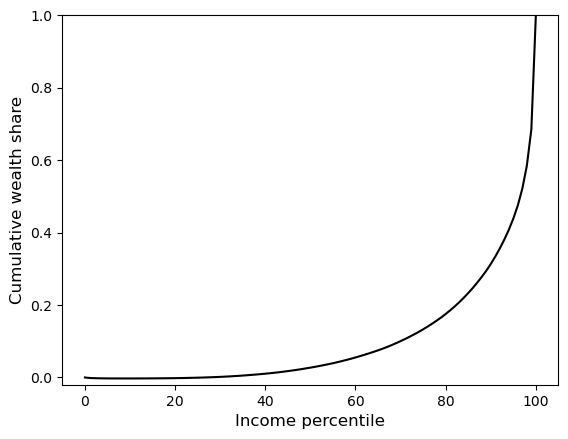

Estimate is center=0.9891294009546624, spread=0.0
Lorenz distance is 42.33840938422956
Average MPC for all consumers is 0.099
Average MPC in the top percentile of W/Y is 0.069
Average MPC in the top decile of W/Y is 0.071
Average MPC in the top quintile of W/Y is 0.072
Average MPC in the second quintile of W/Y is 0.074
Average MPC in the middle quintile of W/Y is 0.074
Average MPC in the fourth quintile of W/Y is 0.076
Average MPC in the bottom quintile of W/Y is 0.197
Average MPC in the top percentile of y is 0.075
Average MPC in the top decile of y is 0.077
Average MPC in the top quintile of y is 0.084
Average MPC in the second quintile of y is 0.117
Average MPC in the middle quintile of y is 0.119
Average MPC in the fourth quintile of y is 0.082
Average MPC in the bottom quintile of y is 0.092
Average MPC for the employed is 0.096
Average MPC for the unemployed is 0.130
Average MPC for the retired is nan
Of the population with the 1/3 highest MPCs...
65.755% are in the bottom wealth

In [4]:
options = {
    "param_name": param_name,
    "dist_type": dist_type,
    "run_estimation": run_estimation,
    "run_sensitivity": run_sensitivity,
    "find_beta_vs_KY": find_beta_vs_KY,
    "do_tractable": do_tractable,
    "do_param_dist": do_param_dist,
    "do_lifecycle": do_lifecycle,
    "do_agg_shocks": do_agg_shocks,
    "do_liquid": do_liquid,
}


EstimationEconomy = estimate(options, parameters)

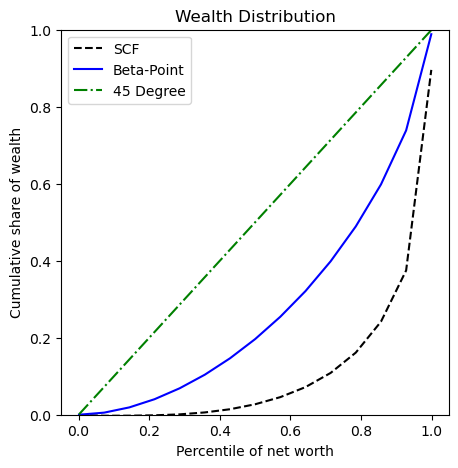

In [5]:
# Construct the Lorenz curves and plot them

pctiles = np.linspace(0.001, 0.999, 15)
SCF_Lorenz_points = get_lorenz_shares(
    SCF_wealth, weights=SCF_weights, percentiles=pctiles
)

sim_wealth = EstimationEconomy.reap_state["aLvl"][0]
sim_Lorenz_points = get_lorenz_shares(sim_wealth, percentiles=pctiles)

# Plot
plt.figure(figsize=(5, 5))
plt.title("Wealth Distribution")
plt.plot(pctiles, SCF_Lorenz_points, "--k", label="SCF")
plt.plot(pctiles, sim_Lorenz_points, "-b", label="Beta-Point")
plt.plot(pctiles, pctiles, "g-.", label="45 Degree")
plt.xlabel("Percentile of net worth")
plt.ylabel("Cumulative share of wealth")
plt.legend(loc=2)
plt.ylim([0, 1])
plt.show("wealth_distribution_1")

In [6]:
print(sim_wealth.shape)

(10000,)


In [7]:
print(EstimationEconomy.agents)

[<code.agents.DoWAgent object at 0x13a7d7040.
Parameters:
cycles: 0
CRRA: 1.0
Rfree: 1.0163522012578616
DiscFac: 0.9891294009546624
LivPrb: [0.99375]
PermGroFac: [1.0]
BoroCnstArt: 0.0
MaxKinks: 400
AgentCount: 10000
aNrmInitMean: -11.512925464970229
aNrmInitStd: 0.0
pLvlInitMean: 0.0
pLvlInitStd: 0.0
PermGroFacAgg: 1.0
T_age: 400
T_cycle: 1
PerfMITShk: False
aXtraMin: 1e-05
aXtraMax: 20
aXtraNestFac: 3
aXtraCount: 20
aXtraExtra: [None]
PermShkStd: [0.06030226891555272]
PermShkCount: 5
TranShkStd: [0.2]
TranShkCount: 5
UnempPrb: 0.07
UnempPrbRet: None
IncUnemp: 0.15
IncUnempRet: None
tax_rate: 0.0
T_retire: 0
vFuncBool: False
CubicBool: False
neutral_measure: False
NewbornTransShk: False
T_sim: 1200
IndL: 1.1111111111111112>]


## Time Preference Heterogeneneity

Our specific approach is to replace the assumption that all households have the same time
preference factor with an assumption that, for some dispersion $\nabla$, time
preference factors are distributed uniformly in the population between
$\grave{\Discount}-\nabla$ and $\grave{\Discount}+\nabla$ (for this reason, the model is referred to as the $\Discount$-Dist model). Then,
using simulations, we search for the values of $\grave{\Discount}$ and
$\nabla$ for which the model best matches the fraction of net worth held by the top $20$, $40$, $60$, and $80$ percent of the population, while at the same time matching
the aggregate capital-to-output ratio from the perfect foresight
model. Specifically, defining $w_{i}$ and $\omega _{i}$ as the proportion of total aggregate net worth held by the top $i$ percent in our model and in the data, respectively, we solve the following minimization problem:

$$
\{\grave{\Discount}, \nabla\}= \underset{\{{\Discount}, \nabla\}}{\text{argmin} }\Big(\sum_\text{i=20, 40, 60, 80}
  \big(w_{i}({\Discount}, \nabla)-\omega _{i}\big)^{2}\Big)^{1/2}
$$

subject to the constraint that the aggregate wealth (net worth)-to-output ratio in the model matches the aggregate
capital-to-output ratio from the perfect foresight model ($\KLev_{PF}/\YLev_{PF}$). When solving the problem for the FBS specification we shut down the aggregate shocks (practically, this does not affect the estimates given their small size).

$$\KLev / \YLev = \KLev_{PF} / \YLev_{PF}$$

The solution to this problem is $\{\grave{\Discount}, \nabla\}=\{0.9867, 0.0067\}$
, so that the discount factors are evenly spread roughly between 0.98 and 0.99. We call the optimal value of the objective function the 'Lorenz distance' and use it as a measure of fit of the models.

The introduction of even such a relatively modest amount of time
preference heterogeneity sharply improves the model's fit to the targeted
proportions of wealth holdings, bringing it reasonably in line with the data.


In [8]:
"""
This options file establishes the second simplest model specification possible:
with heterogeneity, no aggregate shocks, perpetual youth model, matching net worth.
"""
do_param_dist = True  # Do param-dist version if True, param-point if False
do_lifecycle = False  # Use lifecycle model if True, perpetual youth if False
do_agg_shocks = False  # Solve the FBS aggregate shocks version of the model
do_liquid = False  # Matches liquid assets data when True, net worth data when False
do_tractable = False  #

Beginning an estimation with the specification name PYbetaDistIndNetWorth...
0.9809571428571429
0.9828714285714286
0.9847857142857143
0.9867
0.9886142857142858
0.9905285714285714
0.9924428571428572


GPFRaw                 = 0.996998 
GPFNrm                 = 1.000255 
GPFAggLivPrb           = 0.990767 
Thorn = APF            = 0.996998 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.974826 
WRPF                   = 0.068238 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 1.002835 
GPFNrm                 = 1.006110 
GPFAggLivPrb           = 0.996567 
Thorn = APF            = 1.002835 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.980533 
WRPF                   = 0.068637 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.998944 
GPFNrm                 = 1.002206 
GPFAggLivPrb           = 0.992700 
Thorn = APF            = 0.998944 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.976728 
WRPF                   = 0.068371 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 0.9867 and got -0.3351645608890106
find_lorenz_distance_at_target_KY tried spread = 0.0067 and got 8.374355975328365
0.9809571528571429
0.9828714385714287
0.9847857242857143
0.9867000100000001
0.9886142957142858
0.9905285814285715
0.9924428671428572


GPFRaw                 = 0.996998 
GPFNrm                 = 1.000255 
GPFAggLivPrb           = 0.990767 
Thorn = APF            = 0.996998 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.974826 
WRPF                   = 0.068238 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.998944 
GPFNrm                 = 1.002206 
GPFAggLivPrb           = 0.992700 
Thorn = APF            = 0.998944 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.976728 
WRPF                   = 0.068371 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 1.000889 
GPFNrm                 = 1.004158 
GPFAggLivPrb           = 0.994634 
Thorn = APF            = 1.000889 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.978631 
WRPF                   = 0.068504 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 0.9867000100000001 and got -0.3351304252956435
find_lorenz_distance_at_target_KY tried spread = 0.0067 and got 8.374339571492953
0.9809571342857143
0.9828714228571429
0.9847857114285714
0.9867
0.9886142885714286
0.9905285771428571
0.9924428657142857


GPFRaw                 = 0.996998 
GPFNrm                 = 1.000255 
GPFAggLivPrb           = 0.990767 
Thorn = APF            = 0.996998 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.974826 
WRPF                   = 0.068238 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.998944 
GPFNrm                 = 1.002206 
GPFAggLivPrb           = 0.992700 
Thorn = APF            = 0.998944 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.976728 
WRPF                   = 0.068371 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 1.000889 
GPFNrm                 = 1.004158 
GPFAggLivPrb           = 0.994634 
Thorn = APF            = 1.000889 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.978631 
WRPF                   = 0.068504 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 0.9867 and got -0.3351439379006109
find_lorenz_distance_at_target_KY tried spread = 0.00670001 and got 8.374316485247475
0.9881428571428571
0.9904285714285713
0.9927142857142857
0.9949999999999999
0.9972857142857141
0.9995714285714284
1.0018571428571428


GPFRaw                 = 1.004301 
GPFNrm                 = 1.007582 
GPFAggLivPrb           = 0.998024 
Thorn = APF            = 1.004301 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.981967 
WRPF                   = 0.068738 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 1.006624 
GPFNrm                 = 1.009912 
GPFAggLivPrb           = 1.000333 
Thorn = APF            = 1.006624 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.984238 
WRPF                   = 0.068897 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 1.008947 
GPFNrm                 = 1.012243 
GPFAggLivPrb           = 1.002641 
Thorn = APF            = 1.008947 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.986510 
WRPF                   = 0.069056 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 0.995 and got 150.60578114583635
find_lorenz_distance_at_target_KY tried spread = 0.008 and got 2.439628799116395
0.988142847142857
0.9904285614285714
0.9927142757142856
0.99499999
0.9972857042857143
0.9995714185714285
1.0018571328571428


GPFRaw                 = 1.004301 
GPFNrm                 = 1.007582 
GPFAggLivPrb           = 0.998024 
Thorn = APF            = 1.004301 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.981967 
WRPF                   = 0.068738 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 1.006624 
GPFNrm                 = 1.009912 
GPFAggLivPrb           = 1.000333 
Thorn = APF            = 1.006624 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.984238 
WRPF                   = 0.068897 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 1.008947 
GPFNrm                 = 1.012243 
GPFAggLivPrb           = 1.002641 
Thorn = APF            = 1.008947 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.986510 
WRPF                   = 0.069056 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 0.99499999 and got 150.60530715556143
find_lorenz_distance_at_target_KY tried spread = 0.008 and got 2.439619746748951
0.9881428657142858
0.9904285771428571
0.9927142885714286
0.995
0.9972857114285714
0.9995714228571428
1.0018571342857143


GPFRaw                 = 1.004301 
GPFNrm                 = 1.007582 
GPFAggLivPrb           = 0.998024 
Thorn = APF            = 1.004301 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.981967 
WRPF                   = 0.068738 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 1.006624 
GPFNrm                 = 1.009912 
GPFAggLivPrb           = 1.000333 
Thorn = APF            = 1.006624 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.984238 
WRPF                   = 0.068897 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 1.008947 
GPFNrm                 = 1.012243 
GPFAggLivPrb           = 1.002641 
Thorn = APF            = 1.008947 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.986510 
WRPF                   = 0.069056 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 0.995 and got 150.60551117683826
find_lorenz_distance_at_target_KY tried spread = 0.00799999 and got 2.439605532395265
0.9827065450839966
0.9847112571559328
0.986715969227869
0.9887206812998052
0.9907253933717414
0.9927301054436776
0.9947348175156138


GPFRaw                 = 0.998776 
GPFNrm                 = 1.002038 
GPFAggLivPrb           = 0.992534 
Thorn = APF            = 0.998776 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.976565 
WRPF                   = 0.068360 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 1.000813 
GPFNrm                 = 1.004083 
GPFAggLivPrb           = 0.994558 
Thorn = APF            = 1.000813 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.978557 
WRPF                   = 0.068499 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 1.002851 
GPFNrm                 = 1.006127 
GPFAggLivPrb           = 0.996583 
Thorn = APF            = 1.002851 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.980549 
WRPF                   = 0.068638 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 0.9887206812998052 and got 10.314451409727427
find_lorenz_distance_at_target_KY tried spread = 0.007016492251776719 and got 5.527596484489049
0.9827065550839966
0.9847112671559328
0.986715979227869
0.9887206912998052
0.9907254033717414
0.9927301154436776
0.9947348275156138


GPFRaw                 = 0.998776 
GPFNrm                 = 1.002038 
GPFAggLivPrb           = 0.992534 
Thorn = APF            = 0.998776 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.976565 
WRPF                   = 0.068360 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 1.000813 
GPFNrm                 = 1.004083 
GPFAggLivPrb           = 0.994558 
Thorn = APF            = 1.000813 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.978557 
WRPF                   = 0.068499 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 1.002851 
GPFNrm                 = 1.006127 
GPFAggLivPrb           = 0.996583 
Thorn = APF            = 1.002851 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.980549 
WRPF                   = 0.068638 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 0.9887206912998052 and got 10.314516908399083
find_lorenz_distance_at_target_KY tried spread = 0.007016492251776719 and got 5.527592224790313
0.982706536512568
0.9847112514416471
0.9867159663707261
0.9887206812998052
0.9907253962288842
0.9927301111579633
0.9947348260870423


GPFRaw                 = 0.998776 
GPFNrm                 = 1.002038 
GPFAggLivPrb           = 0.992534 
Thorn = APF            = 0.998776 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.976565 
WRPF                   = 0.068360 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 1.000813 
GPFNrm                 = 1.004083 
GPFAggLivPrb           = 0.994558 
Thorn = APF            = 1.000813 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.978557 
WRPF                   = 0.068499 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 1.002851 
GPFNrm                 = 1.006127 
GPFAggLivPrb           = 0.996583 
Thorn = APF            = 1.002851 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.980549 
WRPF                   = 0.068638 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 0.9887206812998052 and got 10.314488608740627
find_lorenz_distance_at_target_KY tried spread = 0.007016502251776719 and got 5.527562326434886
0.9810850471734273
0.9830059442440219
0.9849268413146166
0.9868477383852112
0.9887686354558058
0.9906895325264006
0.9926104295969952


GPFRaw                 = 0.997128 
GPFNrm                 = 1.000385 
GPFAggLivPrb           = 0.990896 
Thorn = APF            = 0.997128 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.974953 
WRPF                   = 0.068247 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.999080 
GPFNrm                 = 1.002344 
GPFAggLivPrb           = 0.992836 
Thorn = APF            = 0.999080 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.976862 
WRPF                   = 0.068380 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 1.001033 
GPFNrm                 = 1.004302 
GPFAggLivPrb           = 0.994776 
Thorn = APF            = 1.001033 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.978771 
WRPF                   = 0.068514 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 0.9868477383852112 and got 0.23075611948523544
find_lorenz_distance_at_target_KY tried spread = 0.006723139747081282 and got 8.05329806953574
0.9810850571734273
0.9830059542440219
0.9849268513146167
0.9868477483852113
0.9887686454558059
0.9906895425264006
0.9926104395969952


GPFRaw                 = 0.997128 
GPFNrm                 = 1.000385 
GPFAggLivPrb           = 0.990896 
Thorn = APF            = 0.997128 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.974953 
WRPF                   = 0.068247 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.999080 
GPFNrm                 = 1.002344 
GPFAggLivPrb           = 0.992836 
Thorn = APF            = 0.999080 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.976862 
WRPF                   = 0.068380 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 1.001033 
GPFNrm                 = 1.004302 
GPFAggLivPrb           = 0.994776 
Thorn = APF            = 1.001033 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.978771 
WRPF                   = 0.068514 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 0.9868477483852113 and got 0.23079195595676083
find_lorenz_distance_at_target_KY tried spread = 0.006723139747081282 and got 8.05328328814026
0.9810850386019987
0.9830059385297362
0.9849268384574738
0.9868477383852112
0.9887686383129487
0.9906895382406863
0.9926104381684238


GPFRaw                 = 0.997128 
GPFNrm                 = 1.000385 
GPFAggLivPrb           = 0.990896 
Thorn = APF            = 0.997128 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.974953 
WRPF                   = 0.068247 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.999080 
GPFNrm                 = 1.002344 
GPFAggLivPrb           = 0.992836 
Thorn = APF            = 0.999080 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.976862 
WRPF                   = 0.068380 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 1.001033 
GPFNrm                 = 1.004302 
GPFAggLivPrb           = 0.994776 
Thorn = APF            = 1.001033 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.978771 
WRPF                   = 0.068514 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 0.9868477383852112 and got 0.23077765294213748
find_lorenz_distance_at_target_KY tried spread = 0.006723149747081282 and got 8.053259448234186
0.9809854279442268
0.9829277858623233
0.9848701437804198
0.9868125016985163
0.9887548596166128
0.9906972175347093
0.9926395754528058


GPFRaw                 = 0.997027 
GPFNrm                 = 1.000283 
GPFAggLivPrb           = 0.990795 
Thorn = APF            = 0.997027 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.974854 
WRPF                   = 0.068240 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.999001 
GPFNrm                 = 1.002264 
GPFAggLivPrb           = 0.992757 
Thorn = APF            = 0.999001 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.976784 
WRPF                   = 0.068375 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 1.000975 
GPFNrm                 = 1.004245 
GPFAggLivPrb           = 0.994719 
Thorn = APF            = 1.000975 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.978715 
WRPF                   = 0.068510 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 0.9868125016985163 and got 0.266659568602595
find_lorenz_distance_at_target_KY tried spread = 0.0067982527133377225 and got 7.8167750900117685
0.9809854379442269
0.9829277958623234
0.9848701537804199
0.9868125116985164
0.9887548696166129
0.9906972275347093
0.9926395854528058


GPFRaw                 = 0.997027 
GPFNrm                 = 1.000283 
GPFAggLivPrb           = 0.990795 
Thorn = APF            = 0.997027 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.974854 
WRPF                   = 0.068240 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.999001 
GPFNrm                 = 1.002264 
GPFAggLivPrb           = 0.992757 
Thorn = APF            = 0.999001 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.976784 
WRPF                   = 0.068375 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 1.000975 
GPFNrm                 = 1.004245 
GPFAggLivPrb           = 0.994719 
Thorn = APF            = 1.000975 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.978715 
WRPF                   = 0.068510 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 0.9868125116985164 and got 0.2666954457893631
find_lorenz_distance_at_target_KY tried spread = 0.0067982527133377225 and got 7.816760282359912
0.9809854193727983
0.9829277801480376
0.984870140923277
0.9868125016985163
0.9887548624737557
0.990697223248995
0.9926395840242344


GPFRaw                 = 0.997027 
GPFNrm                 = 1.000283 
GPFAggLivPrb           = 0.990795 
Thorn = APF            = 0.997027 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.974854 
WRPF                   = 0.068240 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.999001 
GPFNrm                 = 1.002264 
GPFAggLivPrb           = 0.992757 
Thorn = APF            = 0.999001 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.976784 
WRPF                   = 0.068375 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 1.000975 
GPFNrm                 = 1.004245 
GPFAggLivPrb           = 0.994719 
Thorn = APF            = 1.000975 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.978715 
WRPF                   = 0.068510 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 0.9868125016985163 and got 0.2666812235483942
find_lorenz_distance_at_target_KY tried spread = 0.0067982627133377225 and got 7.816736886976951
0.9805869510274251
0.982615152335529
0.9846433536436328
0.9866715549517366
0.9886997562598405
0.9907279575679443
0.9927561588760482


GPFRaw                 = 0.996622 
GPFNrm                 = 0.999877 
GPFAggLivPrb           = 0.990393 
Thorn = APF            = 0.996622 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.974458 
WRPF                   = 0.068212 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.998683 
GPFNrm                 = 1.001945 
GPFAggLivPrb           = 0.992441 
Thorn = APF            = 0.998683 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.976474 
WRPF                   = 0.068353 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 1.000744 
GPFNrm                 = 1.004013 
GPFAggLivPrb           = 0.994490 
Thorn = APF            = 1.000744 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.978489 
WRPF                   = 0.068494 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 0.9866715549517366 and got 0.41779836675687854
find_lorenz_distance_at_target_KY tried spread = 0.0070987045783634855 and got 6.902499579890175
0.9805869610274252
0.982615162335529
0.9846433636436328
0.9866715649517367
0.9886997662598406
0.9907279675679443
0.9927561688760482


GPFRaw                 = 0.996622 
GPFNrm                 = 0.999877 
GPFAggLivPrb           = 0.990393 
Thorn = APF            = 0.996622 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.974458 
WRPF                   = 0.068212 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.998683 
GPFNrm                 = 1.001945 
GPFAggLivPrb           = 0.992441 
Thorn = APF            = 0.998683 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.976474 
WRPF                   = 0.068353 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 1.000744 
GPFNrm                 = 1.004013 
GPFAggLivPrb           = 0.994490 
Thorn = APF            = 1.000744 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.978489 
WRPF                   = 0.068494 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 0.9866715649517367 and got 0.41783444129488956
find_lorenz_distance_at_target_KY tried spread = 0.0070987045783634855 and got 6.90248473984727
0.9805869424559964
0.9826151466212432
0.9846433507864899
0.9866715549517366
0.9886997591169834
0.9907279632822301
0.9927561674474769


GPFRaw                 = 0.996622 
GPFNrm                 = 0.999877 
GPFAggLivPrb           = 0.990393 
Thorn = APF            = 0.996622 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.974458 
WRPF                   = 0.068212 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.998683 
GPFNrm                 = 1.001945 
GPFAggLivPrb           = 0.992441 
Thorn = APF            = 0.998683 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.976474 
WRPF                   = 0.068353 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 1.000744 
GPFNrm                 = 1.004013 
GPFAggLivPrb           = 0.994490 
Thorn = APF            = 1.000744 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.978489 
WRPF                   = 0.068494 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 0.9866715549517366 and got 0.41782051323664504
find_lorenz_distance_at_target_KY tried spread = 0.0070987145783634855 and got 6.902463028997948
0.9778626978481874
0.9801484121339017
0.9824341264196159
0.9847198407053303
0.9870055549910446
0.9892912692767588
0.9915769835624731


GPFRaw                 = 0.993853 
GPFNrm                 = 0.997099 
GPFAggLivPrb           = 0.987641 
Thorn = APF            = 0.993853 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.971751 
WRPF                   = 0.068023 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.996176 
GPFNrm                 = 0.999430 
GPFAggLivPrb           = 0.989950 
Thorn = APF            = 0.996176 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.974022 
WRPF                   = 0.068182 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.998499 
GPFNrm                 = 1.001761 
GPFAggLivPrb           = 0.992258 
Thorn = APF            = 0.998499 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.976294 
WRPF                   = 0.068341 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 0.9847198407053303 and got -3.5773834017270083
find_lorenz_distance_at_target_KY tried spread = 0.008 and got 7.786583795823769
0.9778627078481874
0.9801484221339017
0.982434136419616
0.9847198507053303
0.9870055649910446
0.9892912792767589
0.9915769935624732


GPFRaw                 = 0.993853 
GPFNrm                 = 0.997099 
GPFAggLivPrb           = 0.987641 
Thorn = APF            = 0.993853 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.971751 
WRPF                   = 0.068023 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.996176 
GPFNrm                 = 0.999430 
GPFAggLivPrb           = 0.989950 
Thorn = APF            = 0.996176 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.974022 
WRPF                   = 0.068182 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.998499 
GPFNrm                 = 1.001761 
GPFAggLivPrb           = 0.992258 
Thorn = APF            = 0.998499 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.976294 
WRPF                   = 0.068341 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 0.9847198507053303 and got -3.5773603841026125
find_lorenz_distance_at_target_KY tried spread = 0.008 and got 7.786551870557106
0.977862706419616
0.9801484178481874
0.9824341292767589
0.9847198407053303
0.9870055521339016
0.9892912635624731
0.9915769749910445


GPFRaw                 = 0.993853 
GPFNrm                 = 0.997099 
GPFAggLivPrb           = 0.987641 
Thorn = APF            = 0.993853 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.971751 
WRPF                   = 0.068023 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.996176 
GPFNrm                 = 0.999430 
GPFAggLivPrb           = 0.989950 
Thorn = APF            = 0.996176 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.974022 
WRPF                   = 0.068182 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.998499 
GPFNrm                 = 1.001761 
GPFAggLivPrb           = 0.992258 
Thorn = APF            = 0.998499 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.976294 
WRPF                   = 0.068341 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 0.9847198407053303 and got -3.577398949294393
find_lorenz_distance_at_target_KY tried spread = 0.00799999 and got 7.7866267517816325
0.9803278422793027
0.9823805361220074
0.984433229964712
0.9864859238074167
0.9885386176501214
0.9905913114928261
0.9926440053355308


GPFRaw                 = 0.996358 
GPFNrm                 = 0.999613 
GPFAggLivPrb           = 0.990131 
Thorn = APF            = 0.996358 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.974201 
WRPF                   = 0.068194 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.998445 
GPFNrm                 = 1.001706 
GPFAggLivPrb           = 0.992204 
Thorn = APF            = 0.998445 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.976241 
WRPF                   = 0.068337 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 1.000531 
GPFNrm                 = 1.003799 
GPFAggLivPrb           = 0.994278 
Thorn = APF            = 1.000531 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.978281 
WRPF                   = 0.068480 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 0.9864859238074167 and got -0.05147233694264308
find_lorenz_distance_at_target_KY tried spread = 0.0071844284494663995 and got 6.876127144818605
0.9803278522793027
0.9823805461220074
0.9844332399647121
0.9864859338074168
0.9885386276501215
0.9905913214928261
0.9926440153355308


GPFRaw                 = 0.996358 
GPFNrm                 = 0.999613 
GPFAggLivPrb           = 0.990131 
Thorn = APF            = 0.996358 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.974201 
WRPF                   = 0.068194 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.998445 
GPFNrm                 = 1.001706 
GPFAggLivPrb           = 0.992204 
Thorn = APF            = 0.998445 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.976241 
WRPF                   = 0.068337 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 1.000531 
GPFNrm                 = 1.003799 
GPFAggLivPrb           = 0.994278 
Thorn = APF            = 1.000531 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.978281 
WRPF                   = 0.068480 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 0.9864859338074168 and got -0.051437743228133215
find_lorenz_distance_at_target_KY tried spread = 0.0071844284494663995 and got 6.876111004044893
0.9803278337078741
0.9823805304077217
0.9844332271075692
0.9864859238074167
0.9885386205072643
0.9905913172071118
0.9926440139069593


GPFRaw                 = 0.996358 
GPFNrm                 = 0.999613 
GPFAggLivPrb           = 0.990131 
Thorn = APF            = 0.996358 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.974201 
WRPF                   = 0.068194 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.998445 
GPFNrm                 = 1.001706 
GPFAggLivPrb           = 0.992204 
Thorn = APF            = 0.998445 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.976241 
WRPF                   = 0.068337 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 1.000531 
GPFNrm                 = 1.003799 
GPFAggLivPrb           = 0.994278 
Thorn = APF            = 1.000531 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.978281 
WRPF                   = 0.068480 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 0.9864859238074167 and got -0.051450890692144924
find_lorenz_distance_at_target_KY tried spread = 0.0071844384494663995 and got 6.876090402837406
0.9792717771871179
0.9815574914728322
0.9838432057585464
0.9861289200442608
0.9884146343299751
0.9907003486156893
0.9929860629014037


GPFRaw                 = 0.995285 
GPFNrm                 = 0.998536 
GPFAggLivPrb           = 0.989064 
Thorn = APF            = 0.995285 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.973151 
WRPF                   = 0.068121 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.997608 
GPFNrm                 = 1.000867 
GPFAggLivPrb           = 0.991373 
Thorn = APF            = 0.997608 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.975423 
WRPF                   = 0.068280 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.999931 
GPFNrm                 = 1.003197 
GPFAggLivPrb           = 0.993682 
Thorn = APF            = 0.999931 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.977694 
WRPF                   = 0.068439 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 0.9861289200442608 and got 0.5047357028594988
find_lorenz_distance_at_target_KY tried spread = 0.008 and got 4.632855895056029
0.9792717871871179
0.9815575014728323
0.9838432157585465
0.9861289300442608
0.9884146443299752
0.9907003586156894
0.9929860729014037


GPFRaw                 = 0.995285 
GPFNrm                 = 0.998536 
GPFAggLivPrb           = 0.989065 
Thorn = APF            = 0.995285 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.973151 
WRPF                   = 0.068121 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.997608 
GPFNrm                 = 1.000867 
GPFAggLivPrb           = 0.991373 
Thorn = APF            = 0.997608 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.975423 
WRPF                   = 0.068280 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.999931 
GPFNrm                 = 1.003197 
GPFAggLivPrb           = 0.993682 
Thorn = APF            = 0.999931 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.977694 
WRPF                   = 0.068439 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 0.9861289300442608 and got 0.5047713838216765
find_lorenz_distance_at_target_KY tried spread = 0.008 and got 4.6328405945046045
0.9792717857585466
0.9815574971871179
0.9838432086156894
0.9861289200442608
0.9884146314728322
0.9907003429014036
0.992986054329975


GPFRaw                 = 0.995285 
GPFNrm                 = 0.998536 
GPFAggLivPrb           = 0.989065 
Thorn = APF            = 0.995285 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.973151 
WRPF                   = 0.068121 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.997608 
GPFNrm                 = 1.000867 
GPFAggLivPrb           = 0.991373 
Thorn = APF            = 0.997608 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.975423 
WRPF                   = 0.068280 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.999931 
GPFNrm                 = 1.003197 
GPFAggLivPrb           = 0.993682 
Thorn = APF            = 0.999931 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.977694 
WRPF                   = 0.068439 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 0.9861289200442608 and got 0.5047127654306944
find_lorenz_distance_at_target_KY tried spread = 0.00799999 and got 4.63288783107085
0.9791991221053343
0.9814848363910487
0.9837705506767629
0.9860562649624772
0.9883419792481916
0.9906276935339058
0.9929134078196201


GPFRaw                 = 0.995211 
GPFNrm                 = 0.998462 
GPFAggLivPrb           = 0.988991 
Thorn = APF            = 0.995211 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.973079 
WRPF                   = 0.068116 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.997534 
GPFNrm                 = 1.000793 
GPFAggLivPrb           = 0.991300 
Thorn = APF            = 0.997534 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.975351 
WRPF                   = 0.068275 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.999857 
GPFNrm                 = 1.003123 
GPFAggLivPrb           = 0.993608 
Thorn = APF            = 0.999857 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.977622 
WRPF                   = 0.068434 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 0.9860562649624772 and got 0.2481129433972722
find_lorenz_distance_at_target_KY tried spread = 0.008 and got 4.746239061051377
0.9791991321053344
0.9814848463910487
0.9837705606767629
0.9860562749624773
0.9883419892481916
0.9906277035339058
0.9929134178196202


GPFRaw                 = 0.995211 
GPFNrm                 = 0.998462 
GPFAggLivPrb           = 0.988991 
Thorn = APF            = 0.995211 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.973079 
WRPF                   = 0.068116 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.997534 
GPFNrm                 = 1.000793 
GPFAggLivPrb           = 0.991300 
Thorn = APF            = 0.997534 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.975351 
WRPF                   = 0.068275 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.999857 
GPFNrm                 = 1.003123 
GPFAggLivPrb           = 0.993608 
Thorn = APF            = 0.999857 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.977622 
WRPF                   = 0.068434 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 0.9860562749624773 and got 0.2481478563698971
find_lorenz_distance_at_target_KY tried spread = 0.008 and got 4.746223206336618
0.979199130676763
0.9814848421053344
0.9837705535339059
0.9860562649624772
0.9883419763910486
0.9906276878196201
0.9929133992481914


GPFRaw                 = 0.995211 
GPFNrm                 = 0.998462 
GPFAggLivPrb           = 0.988991 
Thorn = APF            = 0.995211 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.973079 
WRPF                   = 0.068116 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.997534 
GPFNrm                 = 1.000793 
GPFAggLivPrb           = 0.991300 
Thorn = APF            = 0.997534 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.975351 
WRPF                   = 0.068275 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.999857 
GPFNrm                 = 1.003123 
GPFAggLivPrb           = 0.993608 
Thorn = APF            = 0.999857 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.977622 
WRPF                   = 0.068434 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 0.9860562649624772 and got 0.24809045219073766
find_lorenz_distance_at_target_KY tried spread = 0.00799999 and got 4.74627134080384
0.97919356881642
0.9814792831021343
0.9837649973878485
0.9860507116735628
0.9883364259592772
0.9906221402449914
0.9929078545307057


GPFRaw                 = 0.995206 
GPFNrm                 = 0.998456 
GPFAggLivPrb           = 0.988986 
Thorn = APF            = 0.995206 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.973074 
WRPF                   = 0.068115 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.997529 
GPFNrm                 = 1.000787 
GPFAggLivPrb           = 0.991294 
Thorn = APF            = 0.997529 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.975345 
WRPF                   = 0.068274 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.999852 
GPFNrm                 = 1.003118 
GPFAggLivPrb           = 0.993603 
Thorn = APF            = 0.999852 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.977616 
WRPF                   = 0.068433 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 0.9860507116735628 and got 0.2287408345243893
find_lorenz_distance_at_target_KY tried spread = 0.008 and got 4.755055682371648
0.97919357881642
0.9814792931021343
0.9837650073878486
0.9860507216735629
0.9883364359592772
0.9906221502449915
0.9929078645307058


GPFRaw                 = 0.995206 
GPFNrm                 = 0.998456 
GPFAggLivPrb           = 0.988986 
Thorn = APF            = 0.995206 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.973074 
WRPF                   = 0.068115 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.997529 
GPFNrm                 = 1.000787 
GPFAggLivPrb           = 0.991294 
Thorn = APF            = 0.997529 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.975345 
WRPF                   = 0.068274 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.999852 
GPFNrm                 = 1.003118 
GPFAggLivPrb           = 0.993603 
Thorn = APF            = 0.999852 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.977616 
WRPF                   = 0.068433 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 0.9860507216735629 and got 0.22877568960827865
find_lorenz_distance_at_target_KY tried spread = 0.008 and got 4.755039783646983
0.9791935773878486
0.98147928881642
0.9837650002449915
0.9860507116735628
0.9883364231021342
0.9906221345307057
0.9929078459592771


GPFRaw                 = 0.995206 
GPFNrm                 = 0.998456 
GPFAggLivPrb           = 0.988986 
Thorn = APF            = 0.995206 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.973074 
WRPF                   = 0.068115 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.997529 
GPFNrm                 = 1.000787 
GPFAggLivPrb           = 0.991294 
Thorn = APF            = 0.997529 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.975345 
WRPF                   = 0.068274 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.999852 
GPFNrm                 = 1.003118 
GPFAggLivPrb           = 0.993603 
Thorn = APF            = 0.999852 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.977616 
WRPF                   = 0.068433 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 0.9860507116735628 and got 0.2287183770095229
find_lorenz_distance_at_target_KY tried spread = 0.00799999 and got 4.755087989475204
0.9791933813145572
0.9814790956002716
0.9837648098859858
0.9860505241717001
0.9883362384574145
0.9906219527431287
0.992907667028843


GPFRaw                 = 0.995205 
GPFNrm                 = 0.998456 
GPFAggLivPrb           = 0.988985 
Thorn = APF            = 0.995205 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.973073 
WRPF                   = 0.068115 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000787 
GPFAggLivPrb           = 0.991294 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.975345 
WRPF                   = 0.068274 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.999852 
GPFNrm                 = 1.003117 
GPFAggLivPrb           = 0.993602 
Thorn = APF            = 0.999852 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.977616 
WRPF                   = 0.068433 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 0.9860505241717001 and got 0.228087314555669
find_lorenz_distance_at_target_KY tried spread = 0.008 and got 4.755353801994555
0.9791933913145573
0.9814791056002716
0.9837648198859859
0.9860505341717002
0.9883362484574145
0.9906219627431287
0.9929076770288431


GPFRaw                 = 0.995205 
GPFNrm                 = 0.998456 
GPFAggLivPrb           = 0.988985 
Thorn = APF            = 0.995205 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.973073 
WRPF                   = 0.068115 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000787 
GPFAggLivPrb           = 0.991294 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.975345 
WRPF                   = 0.068274 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.999852 
GPFNrm                 = 1.003117 
GPFAggLivPrb           = 0.993602 
Thorn = APF            = 0.999852 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.977616 
WRPF                   = 0.068433 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 0.9860505341717002 and got 0.22812216768184435
find_lorenz_distance_at_target_KY tried spread = 0.008 and got 4.755337901631876
0.9791933898859859
0.9814791013145573
0.9837648127431288
0.9860505241717001
0.9883362356002715
0.990621947028843
0.9929076584574144


GPFRaw                 = 0.995205 
GPFNrm                 = 0.998456 
GPFAggLivPrb           = 0.988985 
Thorn = APF            = 0.995205 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.973073 
WRPF                   = 0.068115 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000787 
GPFAggLivPrb           = 0.991294 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.975345 
WRPF                   = 0.068274 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.999852 
GPFNrm                 = 1.003117 
GPFAggLivPrb           = 0.993602 
Thorn = APF            = 0.999852 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.977616 
WRPF                   = 0.068433 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 0.9860505241717001 and got 0.22806485817812217
find_lorenz_distance_at_target_KY tried spread = 0.00799999 and got 4.75538611009611
0.9791933814550524
0.9814790957407667
0.983764810026481
0.9860505243121953
0.9883362385979096
0.9906219528836239
0.9929076671693382


GPFRaw                 = 0.995205 
GPFNrm                 = 0.998456 
GPFAggLivPrb           = 0.988985 
Thorn = APF            = 0.995205 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.973073 
WRPF                   = 0.068115 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000787 
GPFAggLivPrb           = 0.991294 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.975345 
WRPF                   = 0.068274 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.999852 
GPFNrm                 = 1.003117 
GPFAggLivPrb           = 0.993602 
Thorn = APF            = 0.999852 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.977616 
WRPF                   = 0.068433 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 0.9860505243121953 and got 0.22808780422469255
find_lorenz_distance_at_target_KY tried spread = 0.008 and got 4.755353578600812
0.9791933914550525
0.9814791057407668
0.983764820026481
0.9860505343121954
0.9883362485979097
0.9906219628836239
0.9929076771693383


GPFRaw                 = 0.999852 
GPFNrm                 = 1.003117 
GPFAggLivPrb           = 0.993602 
Thorn = APF            = 0.999852 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.977616 
WRPF                   = 0.068433 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000787 
GPFAggLivPrb           = 0.991294 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.975345 
WRPF                   = 0.068274 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.995205 
GPFNrm                 = 0.998456 
GPFAggLivPrb           = 0.988985 
Thorn = APF            = 0.995205 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.973073 
WRPF                   = 0.068115 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 0.9860505343121954 and got 0.22812265735200832
find_lorenz_distance_at_target_KY tried spread = 0.008 and got 4.755337678240391
0.9791933900264811
0.9814791014550525
0.9837648128836239
0.9860505243121953
0.9883362357407667
0.9906219471693382
0.9929076585979095


GPFRaw                 = 0.995205 
GPFNrm                 = 0.998456 
GPFAggLivPrb           = 0.988985 
Thorn = APF            = 0.995205 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.973073 
WRPF                   = 0.068115 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000787 
GPFAggLivPrb           = 0.991294 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.975345 
WRPF                   = 0.068274 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.999852 
GPFNrm                 = 1.003117 
GPFAggLivPrb           = 0.993602 
Thorn = APF            = 0.999852 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.977616 
WRPF                   = 0.068433 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 0.9860505243121953 and got 0.22806534784587207
find_lorenz_distance_at_target_KY tried spread = 0.00799999 and got 4.755385886702427
0.9791933814550524
0.9814790957407667
0.983764810026481
0.9860505243121953
0.9883362385979096
0.9906219528836239
0.9929076671693382


GPFRaw                 = 0.995205 
GPFNrm                 = 0.998456 
GPFAggLivPrb           = 0.988985 
Thorn = APF            = 0.995205 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.973073 
WRPF                   = 0.068115 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000787 
GPFAggLivPrb           = 0.991294 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.975345 
WRPF                   = 0.068274 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.999852 
GPFNrm                 = 1.003117 
GPFAggLivPrb           = 0.993602 
Thorn = APF            = 0.999852 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.977616 
WRPF                   = 0.068433 
DiscFacGPFNrmMax    

Estimate is center=0.9860505243121953, spread=0.008, took 420.46502590179443 seconds.
Running in interactive shell (Jupyter notebook or spyder)


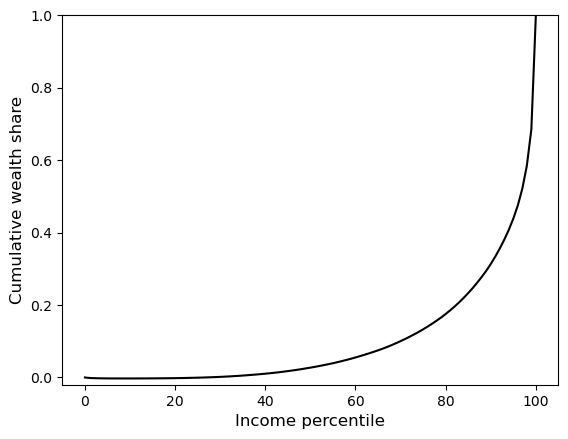

Estimate is center=0.9860505243121953, spread=0.008
Lorenz distance is 4.755353578600812
Average MPC for all consumers is 0.224
Average MPC in the top percentile of W/Y is 0.053
Average MPC in the top decile of W/Y is 0.058
Average MPC in the top quintile of W/Y is 0.062
Average MPC in the second quintile of W/Y is 0.081
Average MPC in the middle quintile of W/Y is 0.170
Average MPC in the fourth quintile of W/Y is 0.286
Average MPC in the bottom quintile of W/Y is 0.522
Average MPC in the top percentile of y is 0.208
Average MPC in the top decile of y is 0.200
Average MPC in the top quintile of y is 0.205
Average MPC in the second quintile of y is 0.234
Average MPC in the middle quintile of y is 0.237
Average MPC in the fourth quintile of y is 0.204
Average MPC in the bottom quintile of y is 0.242
Average MPC for the employed is 0.215
Average MPC for the unemployed is 0.347
Average MPC for the retired is nan
Of the population with the 1/3 highest MPCs...
51.907% are in the bottom weal

In [9]:
options = {
    "param_name": param_name,
    "dist_type": dist_type,
    "run_estimation": run_estimation,
    "run_sensitivity": run_sensitivity,
    "find_beta_vs_KY": find_beta_vs_KY,
    "do_tractable": do_tractable,
    "do_param_dist": do_param_dist,
    "do_lifecycle": do_lifecycle,
    "do_agg_shocks": do_agg_shocks,
    "do_liquid": do_liquid,
    "do_combo_estimation": True,
}


EstimationEconomy = estimate(options, parameters)

In [10]:
# Construct the Lorenz curves and plot them

pctiles = np.linspace(0.001, 0.999, 15)
SCF_Lorenz_points = get_lorenz_shares(
    SCF_wealth, weights=SCF_weights, percentiles=pctiles
)

sim_wealth = np.asarray(EstimationEconomy.reap_state["aLvl"]).flatten()
sim_Lorenz_points = get_lorenz_shares(sim_wealth, percentiles=pctiles)

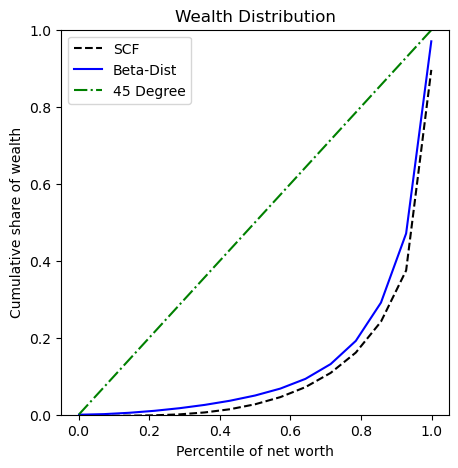

In [11]:
# Plot
plt.figure(figsize=(5, 5))
plt.title("Wealth Distribution")
plt.plot(pctiles, SCF_Lorenz_points, "--k", label="SCF")
plt.plot(pctiles, sim_Lorenz_points, "-b", label="Beta-Dist")
plt.plot(pctiles, pctiles, "g-.", label="45 Degree")
plt.xlabel("Percentile of net worth")
plt.ylabel("Cumulative share of wealth")
plt.legend(loc=2)
plt.ylim([0, 1])
plt.show("wealth_distribution_2")

In [12]:
np.asarray(EstimationEconomy.reap_state["aLvl"]).shape

(7, 2000)

In [13]:
print(sim_wealth.shape)

(14000,)
